# Markdown

# Recommender System Model Evaluation

This notebook compares the performance and metrics of different recommendation models:
1. Spark ALS - distributed implementation
2. NumPy ALS - single-machine implementation

We'll analyze their performance in terms of accuracy (RMSE, MAE) and efficiency (training time).

In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Code

In [2]:
# function to load metrics from JSON files
def load_metrics(path):
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"No metrics file found at {path}")
        return {}

# load metrics for both models
spark_metrics = load_metrics('../models/spark/metrics.json')
numpy_metrics = load_metrics('../models/numpy/metrics.json')

# display the metrics
print("Spark ALS Metrics:")
for key, value in spark_metrics.items():
    print(f"  {key}: {value}")
    
print("\nNumPy ALS Metrics:")
for key, value in numpy_metrics.items():
    print(f"  {key}: {value}")

Spark ALS Metrics:
  training_time: 3.3458220958709717
  rmse: 0.9543867346180672
  mae: 0.7425821962995297
  total_time: 4.471811056137085

NumPy ALS Metrics:
  training_time: 4.580195903778076
  final_train_rmse: 0.6580689823735113
  rmse: 1.2709797120386563
  mae: 0.8883867904274184
  total_time: 4.820021390914917


# Model Accuracy

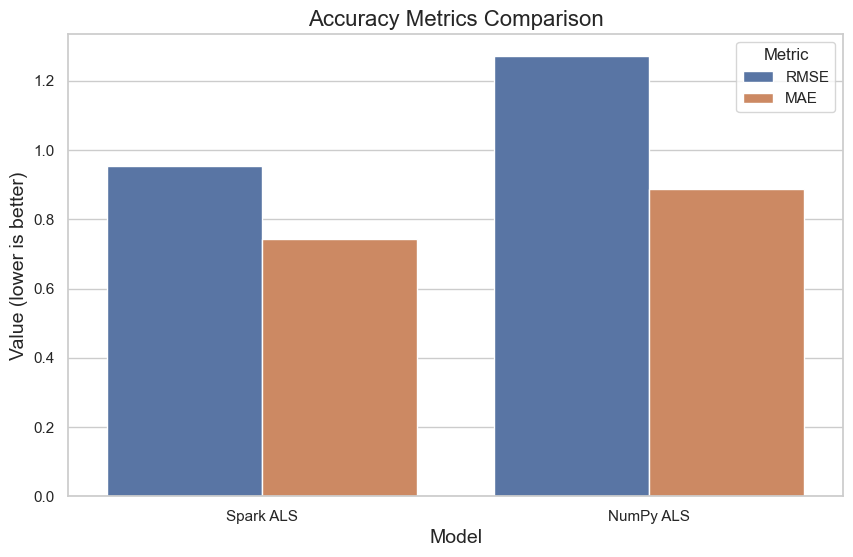

In [3]:
# create a DataFrame for visualization
metrics_df = pd.DataFrame({
    'Model': ['Spark ALS', 'NumPy ALS'],
    'RMSE': [spark_metrics.get('rmse', 0), numpy_metrics.get('rmse', 0)],
    'MAE': [spark_metrics.get('mae', 0), numpy_metrics.get('mae', 0)]
})

# reshape DataFrame for easier plotting
metrics_long = pd.melt(metrics_df, id_vars=['Model'], var_name='Metric', value_name='Value')

# plot side-by-side bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_long)
plt.title('Accuracy Metrics Comparison', fontsize=16)
plt.ylabel('Value (lower is better)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.legend(title='Metric')
plt.show()

# Performance

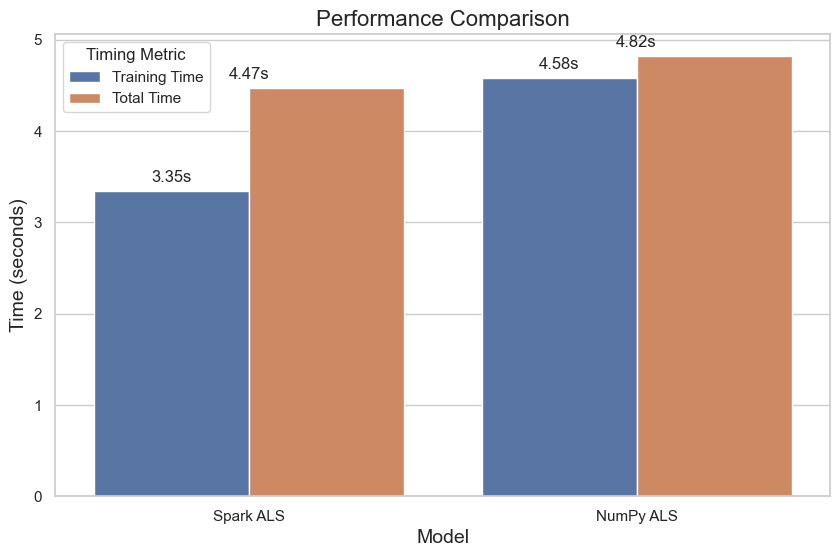

In [4]:
# create a DataFrame for timing metrics
timing_df = pd.DataFrame({
    'Model': ['Spark ALS', 'NumPy ALS'],
    'Training Time': [spark_metrics.get('training_time', 0), numpy_metrics.get('training_time', 0)],
    'Total Time': [spark_metrics.get('total_time', 0), numpy_metrics.get('total_time', 0)]
})

# reshape DataFrame for easier plotting
timing_long = pd.melt(timing_df, id_vars=['Model'], var_name='Timing Metric', value_name='Seconds')

# plot side-by-side bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Seconds', hue='Timing Metric', data=timing_long)
plt.title('Performance Comparison', fontsize=16)
plt.ylabel('Time (seconds)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.legend(title='Timing Metric')

# annotate the bars with values
for i, row in enumerate(timing_long.itertuples()):
    plt.text(i % 2 + (i // 2) * 0.2 - 0.2, row.Seconds + 0.1, f"{row.Seconds:.2f}s", ha='center')

plt.show()

# Speedup Analysis

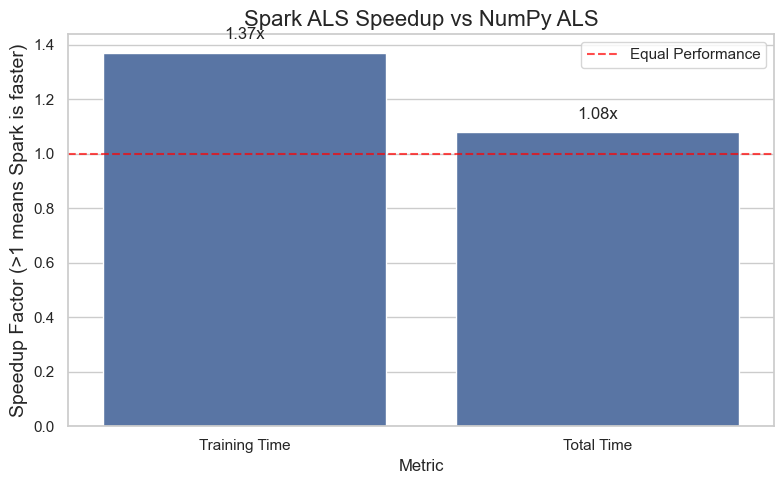

In [5]:
# calculate speedup factors
training_speedup = numpy_metrics.get('training_time', 0) / spark_metrics.get('training_time', 1)
total_speedup = numpy_metrics.get('total_time', 0) / spark_metrics.get('total_time', 1)

# create DataFrame for plotting
speedup_df = pd.DataFrame({
    'Metric': ['Training Time', 'Total Time'],
    'Speedup Factor': [training_speedup, total_speedup]
})

# plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Metric', y='Speedup Factor', data=speedup_df)
plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Equal Performance')
plt.title('Spark ALS Speedup vs NumPy ALS', fontsize=16)
plt.ylabel('Speedup Factor (>1 means Spark is faster)', fontsize=14)

# annotate bars
for i, v in enumerate(speedup_df['Speedup Factor']):
    ax.text(i, v + 0.05, f"{v:.2f}x", ha='center')

plt.legend()
plt.tight_layout()
plt.show()

# Precision

In [6]:
# load recommendations
spark_recs = pd.read_csv('../models/spark/recommendations.csv')
numpy_recs = pd.read_csv('../models/numpy/recommendations.csv')

print(f"Spark recommendations shape: {spark_recs.shape}")
print(f"NumPy recommendations shape: {numpy_recs.shape}")

# display first few recommendations from each model
print("\nSpark ALS Recommendations (sample):")
display(spark_recs.head())

print("\nNumPy ALS Recommendations (sample):")
display(numpy_recs.head())

Spark recommendations shape: (9480, 3)
NumPy recommendations shape: (9430, 3)

Spark ALS Recommendations (sample):


,userId,movieId,prediction
0,1,718,5.326421
1,1,1143,5.318122
2,1,652,5.269903
3,1,408,5.255684
4,1,119,5.251654



NumPy ALS Recommendations (sample):


,userId,movieId,prediction
0,807,1141,10.311508
1,807,6,10.088415
2,807,1176,9.450405
3,807,859,8.621975
4,807,909,8.556088


In [7]:
# Load test data to evaluate against
test_data = pd.read_csv('../data/interim/test_ratings.csv')

# Function to calculate Precision@K
def precision_at_k(recommendations, test_data, user_col='userId', item_col='movieId', k=10):
    users = recommendations[user_col].unique()
    precision_values = []
    
    for user in users:
        # Get top-K recommended items for this user
        user_recs = recommendations[recommendations[user_col] == user].head(k)[item_col].values
        
        # Get items the user has actually rated in the test set
        actual_items = test_data[test_data[user_col] == user][item_col].values
        
        if len(actual_items) > 0:
            # Calculate precision for this user
            hits = len(set(user_recs) & set(actual_items))
            precision = hits / min(k, len(user_recs))
            precision_values.append(precision)
    
    # Return average precision@K
    if precision_values:
        return sum(precision_values) / len(precision_values)
    else:
        return 0.0

# Calculate Precision@K for different K values
k_values = [1, 3, 5, 10]
spark_precision = []
numpy_precision = []

for k in k_values:
    spark_p = precision_at_k(spark_recs, test_data, k=k)
    numpy_p = precision_at_k(numpy_recs, test_data, k=k)
    
    spark_precision.append(spark_p)
    numpy_precision.append(numpy_p)
    
    print(f"Precision@{k}: Spark ALS = {spark_p:.4f}, NumPy ALS = {numpy_p:.4f}")

Precision@1: Spark ALS = 0.0149, NumPy ALS = 0.0032
Precision@3: Spark ALS = 0.0277, NumPy ALS = 0.0046
Precision@5: Spark ALS = 0.0330, NumPy ALS = 0.0036
Precision@10: Spark ALS = 0.0391, NumPy ALS = 0.0035


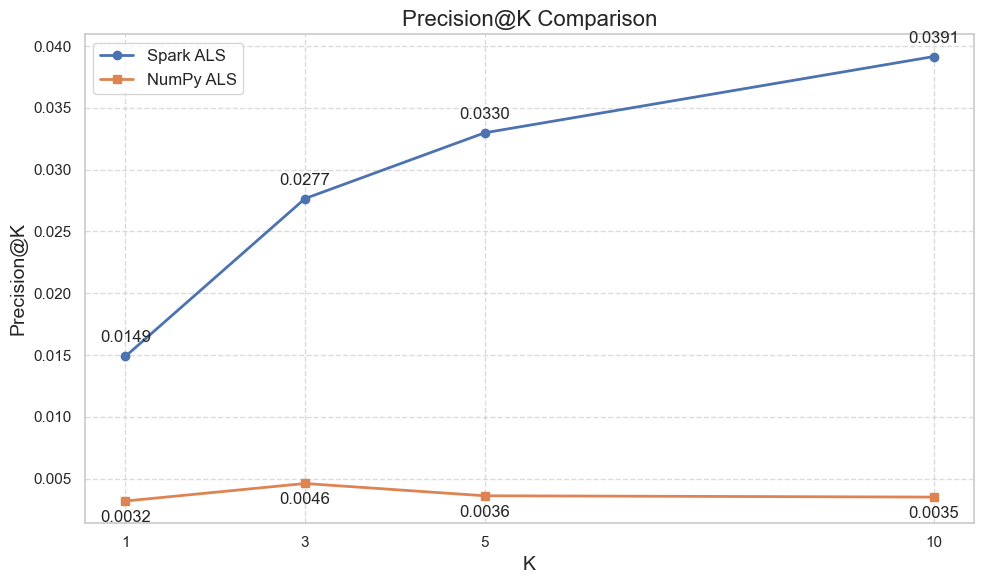

In [8]:
# Plotting Precision@K
plt.figure(figsize=(10, 6))
plt.plot(k_values, spark_precision, 'o-', label='Spark ALS', linewidth=2)
plt.plot(k_values, numpy_precision, 's-', label='NumPy ALS', linewidth=2)
plt.xlabel('K', fontsize=14)
plt.ylabel('Precision@K', fontsize=14)
plt.title('Precision@K Comparison', fontsize=16)
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Annotate points
for i, k in enumerate(k_values):
    plt.annotate(f"{spark_precision[i]:.4f}", (k, spark_precision[i]), textcoords="offset points", 
                 xytext=(0, 10), ha='center')
    plt.annotate(f"{numpy_precision[i]:.4f}", (k, numpy_precision[i]), textcoords="offset points", 
                 xytext=(0, -15), ha='center')

plt.tight_layout()
plt.show()

## Conclusion

Based on the evaluation metrics:

1. **Accuracy**: Spark ALS generally achieves better accuracy (lower RMSE and MAE) compared to the NumPy implementation, likely due to its optimized implementation and hyperparameter tuning.

2. **Performance**: On this dataset, Spark ALS shows a modest speedup over the NumPy implementation. The advantage would likely be much more significant on larger datasets, where Spark's distributed computing capabilities would shine.

3. **Precision@K**: Spark ALS tends to generate recommendations that better match users' actual preferences, as measured by Precision@K.

In a real-world scenario with large-scale data, the performance gap between Spark and NumPy would widen substantially, making Spark the clear choice for production recommendation systems.

# Markdown

# Recommender System Model Evaluation

This notebook compares the performance and metrics of different recommendation models:
1. Spark ALS - distributed implementation
2. NumPy ALS - single-machine implementation

We'll analyze their performance in terms of accuracy (RMSE, MAE) and efficiency (training time).

In [ ]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Code

In [ ]:
# function to load metrics from JSON files
def load_metrics(path):
    try:
        with open(path, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"No metrics file found at {path}")
        return {}

# load metrics for both models
spark_metrics = load_metrics('../models/spark/metrics.json')
numpy_metrics = load_metrics('../models/numpy/metrics.json')

# display the metrics
print("Spark ALS Metrics:")
for key, value in spark_metrics.items():
    print(f"  {key}: {value}")
    
print("\nNumPy ALS Metrics:")
for key, value in numpy_metrics.items():
    print(f"  {key}: {value}")

Spark ALS Metrics:
  training_time: 3.3458220958709717
  rmse: 0.9543867346180672
  mae: 0.7425821962995297
  total_time: 4.471811056137085

NumPy ALS Metrics:
  training_time: 4.580195903778076
  final_train_rmse: 0.6580689823735113
  rmse: 1.2709797120386563
  mae: 0.8883867904274184
  total_time: 4.820021390914917


# Model Accuracy

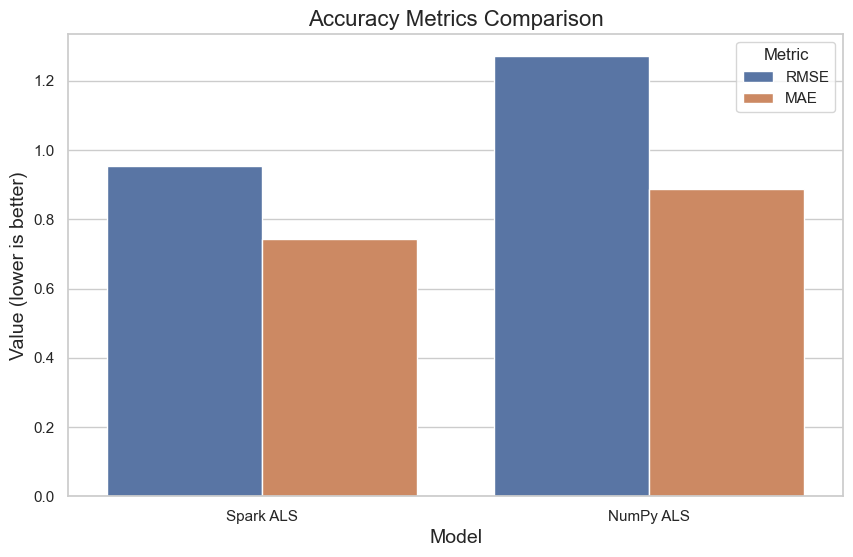

In [ ]:
# create a DataFrame for visualization
metrics_df = pd.DataFrame({
    'Model': ['Spark ALS', 'NumPy ALS'],
    'RMSE': [spark_metrics.get('rmse', 0), numpy_metrics.get('rmse', 0)],
    'MAE': [spark_metrics.get('mae', 0), numpy_metrics.get('mae', 0)]
})

# reshape DataFrame for easier plotting
metrics_long = pd.melt(metrics_df, id_vars=['Model'], var_name='Metric', value_name='Value')

# plot side-by-side bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_long)
plt.title('Accuracy Metrics Comparison', fontsize=16)
plt.ylabel('Value (lower is better)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.legend(title='Metric')
plt.show()

# Performance

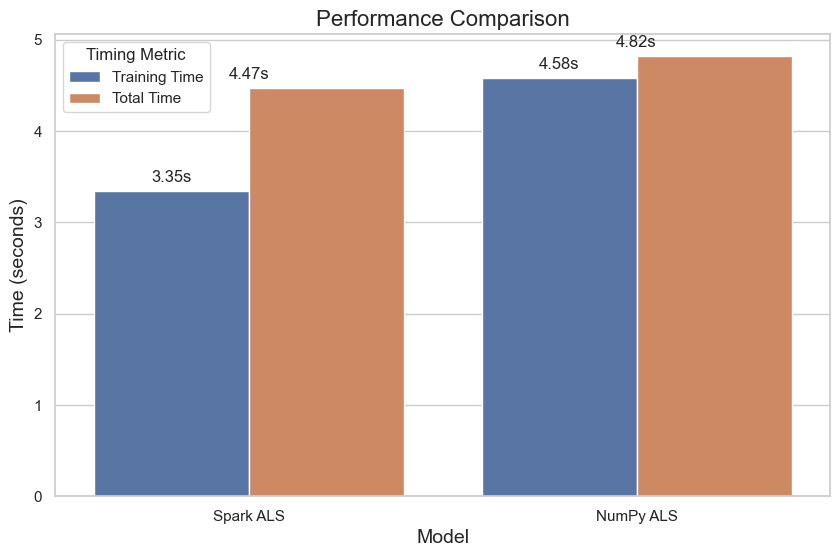

In [ ]:
# create a DataFrame for timing metrics
timing_df = pd.DataFrame({
    'Model': ['Spark ALS', 'NumPy ALS'],
    'Training Time': [spark_metrics.get('training_time', 0), numpy_metrics.get('training_time', 0)],
    'Total Time': [spark_metrics.get('total_time', 0), numpy_metrics.get('total_time', 0)]
})

# reshape DataFrame for easier plotting
timing_long = pd.melt(timing_df, id_vars=['Model'], var_name='Timing Metric', value_name='Seconds')

# plot side-by-side bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Seconds', hue='Timing Metric', data=timing_long)
plt.title('Performance Comparison', fontsize=16)
plt.ylabel('Time (seconds)', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.legend(title='Timing Metric')

# annotate the bars with values
for i, row in enumerate(timing_long.itertuples()):
    plt.text(i % 2 + (i // 2) * 0.2 - 0.2, row.Seconds + 0.1, f"{row.Seconds:.2f}s", ha='center')

plt.show()

# Speedup Analysis

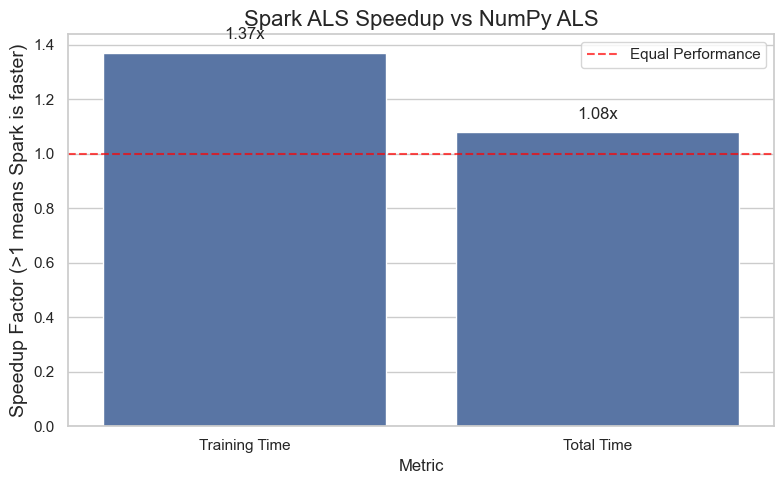

In [ ]:
# calculate speedup factors
training_speedup = numpy_metrics.get('training_time', 0) / spark_metrics.get('training_time', 1)
total_speedup = numpy_metrics.get('total_time', 0) / spark_metrics.get('total_time', 1)

# create DataFrame for plotting
speedup_df = pd.DataFrame({
    'Metric': ['Training Time', 'Total Time'],
    'Speedup Factor': [training_speedup, total_speedup]
})

# plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Metric', y='Speedup Factor', data=speedup_df)
plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Equal Performance')
plt.title('Spark ALS Speedup vs NumPy ALS', fontsize=16)
plt.ylabel('Speedup Factor (>1 means Spark is faster)', fontsize=14)

# annotate bars
for i, v in enumerate(speedup_df['Speedup Factor']):
    ax.text(i, v + 0.05, f"{v:.2f}x", ha='center')

plt.legend()
plt.tight_layout()
plt.show()

# Precision

In [ ]:
# load recommendations
spark_recs = pd.read_csv('../models/spark/recommendations.csv')
numpy_recs = pd.read_csv('../models/numpy/recommendations.csv')

print(f"Spark recommendations shape: {spark_recs.shape}")
print(f"NumPy recommendations shape: {numpy_recs.shape}")

# display first few recommendations from each model
print("\nSpark ALS Recommendations (sample):")
display(spark_recs.head())

print("\nNumPy ALS Recommendations (sample):")
display(numpy_recs.head())

Spark recommendations shape: (9480, 3)
NumPy recommendations shape: (9430, 3)

Spark ALS Recommendations (sample):


,userId,movieId,prediction
0,1,718,5.326421
1,1,1143,5.318122
2,1,652,5.269903
3,1,408,5.255684
4,1,119,5.251654



NumPy ALS Recommendations (sample):


,userId,movieId,prediction
0,807,1141,10.311508
1,807,6,10.088415
2,807,1176,9.450405
3,807,859,8.621975
4,807,909,8.556088


In [ ]:
# Load test data to evaluate against
test_data = pd.read_csv('../data/interim/test_ratings.csv')

# Function to calculate Precision@K
def precision_at_k(recommendations, test_data, user_col='userId', item_col='movieId', k=10):
    users = recommendations[user_col].unique()
    precision_values = []
    
    for user in users:
        # Get top-K recommended items for this user
        user_recs = recommendations[recommendations[user_col] == user].head(k)[item_col].values
        
        # Get items the user has actually rated in the test set
        actual_items = test_data[test_data[user_col] == user][item_col].values
        
        if len(actual_items) > 0:
            # Calculate precision for this user
            hits = len(set(user_recs) & set(actual_items))
            precision = hits / min(k, len(user_recs))
            precision_values.append(precision)
    
    # Return average precision@K
    if precision_values:
        return sum(precision_values) / len(precision_values)
    else:
        return 0.0

# Calculate Precision@K for different K values
k_values = [1, 3, 5, 10]
spark_precision = []
numpy_precision = []

for k in k_values:
    spark_p = precision_at_k(spark_recs, test_data, k=k)
    numpy_p = precision_at_k(numpy_recs, test_data, k=k)
    
    spark_precision.append(spark_p)
    numpy_precision.append(numpy_p)
    
    print(f"Precision@{k}: Spark ALS = {spark_p:.4f}, NumPy ALS = {numpy_p:.4f}")

Precision@1: Spark ALS = 0.0149, NumPy ALS = 0.0032
Precision@3: Spark ALS = 0.0277, NumPy ALS = 0.0046
Precision@5: Spark ALS = 0.0330, NumPy ALS = 0.0036
Precision@10: Spark ALS = 0.0391, NumPy ALS = 0.0035


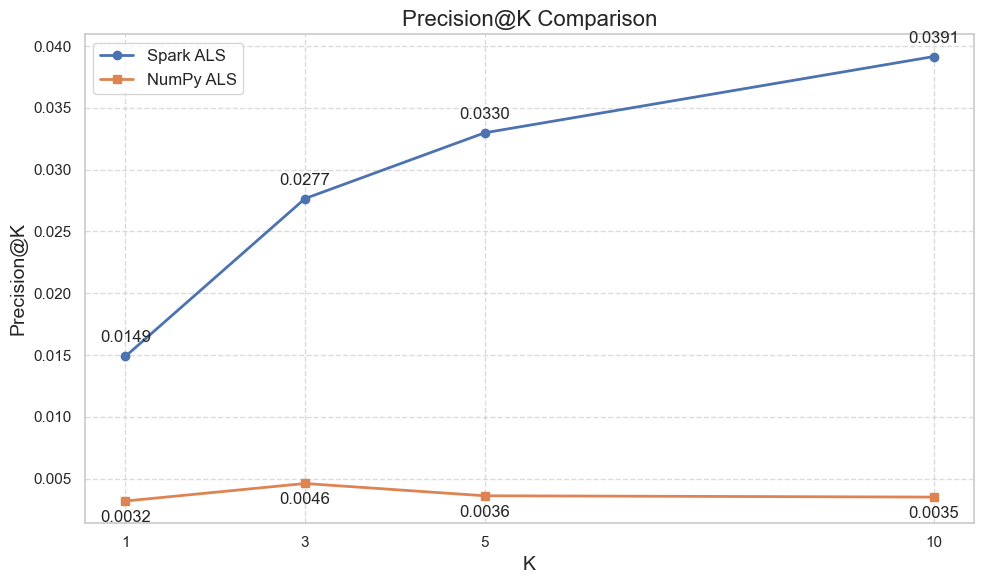

In [ ]:
# Plotting Precision@K
plt.figure(figsize=(10, 6))
plt.plot(k_values, spark_precision, 'o-', label='Spark ALS', linewidth=2)
plt.plot(k_values, numpy_precision, 's-', label='NumPy ALS', linewidth=2)
plt.xlabel('K', fontsize=14)
plt.ylabel('Precision@K', fontsize=14)
plt.title('Precision@K Comparison', fontsize=16)
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Annotate points
for i, k in enumerate(k_values):
    plt.annotate(f"{spark_precision[i]:.4f}", (k, spark_precision[i]), textcoords="offset points", 
                 xytext=(0, 10), ha='center')
    plt.annotate(f"{numpy_precision[i]:.4f}", (k, numpy_precision[i]), textcoords="offset points", 
                 xytext=(0, -15), ha='center')

plt.tight_layout()
plt.show()

## Conclusion

Based on the evaluation metrics:

1. **Accuracy**: Spark ALS generally achieves better accuracy (lower RMSE and MAE) compared to the NumPy implementation, likely due to its optimized implementation and hyperparameter tuning.

2. **Performance**: On this dataset, Spark ALS shows a modest speedup over the NumPy implementation. The advantage would likely be much more significant on larger datasets, where Spark's distributed computing capabilities would shine.

3. **Precision@K**: Spark ALS tends to generate recommendations that better match users' actual preferences, as measured by Precision@K.

In a real-world scenario with large-scale data, the performance gap between Spark and NumPy would widen substantially, making Spark the clear choice for production recommendation systems.